In [26]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

import warnings

%matplotlib inline
warnings.filterwarnings("ignore")
plt.gray()


def plot_images(data: list[np.ndarray, int], show_labels=False, title="", figsize=(5,2)):
    plt.rcParams["figure.figsize"] = figsize
    while len(data) % 5 != 0:
        data.append((np.zeros_like(data[0][0]), ""))

    for i, (x, y) in enumerate(data):
        ax = plt.subplot(len(data) // 5, 5, i+1)
        if show_labels:
            ax.set_title(str(y))
        ax.imshow(x)
        ax.axis('off')
    
    plt.suptitle(title, fontsize=12)
    plt.tight_layout()
    plt.show()

<Figure size 800x300 with 0 Axes>

# Visualize dataset

In [44]:
def get_image(row):
    return np.array(row[1:]).reshape((28, 28))

In [27]:
train = pd.read_csv("data/d1.csv")
test = pd.read_csv("data/mnist_test.csv")

In [28]:
train.shape[0], test.shape[0]

(60000, 10000)

In [29]:
train.head()

,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


<Axes: xlabel='label', ylabel='count'>

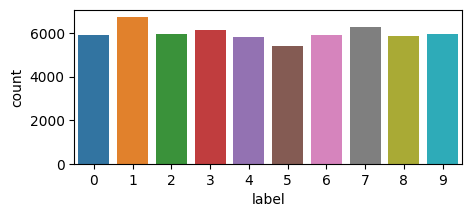

In [150]:
plt.rcParams["figure.figsize"] = (5, 2)
sns.countplot(train, x="label")

<Axes: xlabel='label', ylabel='count'>

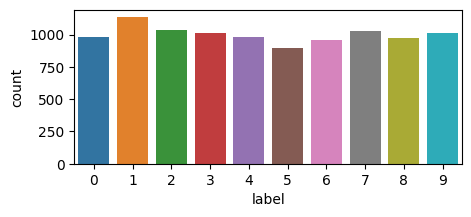

In [151]:
plt.rcParams["figure.figsize"] = (5, 2)
sns.countplot(test, x="label")

In [45]:
from collections import defaultdict

train_data = defaultdict(list)
for _, raw in train.iterrows():
    img = get_image(raw)
    train_data[raw[0]].append(img)

for k in train_data.keys():
    train_data[k] = np.stack(train_data[k])

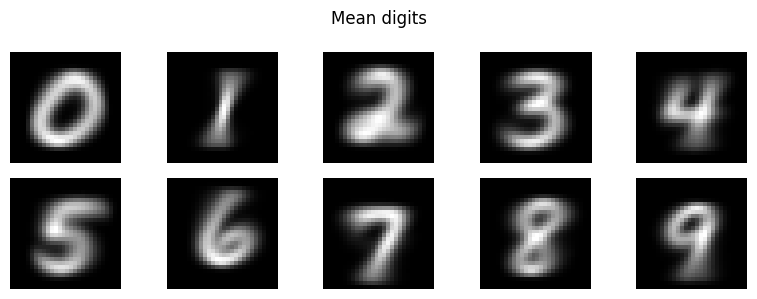

In [46]:
mean_images = [train_data[i].mean(axis=0).astype(np.uint8) for i in range(10)]
plot_images(list(zip(mean_images, range(10))), title="Mean digits", figsize=(8, 3))

In [35]:
# Save images in local storage

# from pathlib import Path
# import cv2

# for k, v in train_data.items():
#     data_dir = Path(f"data/{k}")
#     data_dir.mkdir(parents=True, exist_ok=True)
#     for i, img in enumerate(v):
#         cv2.imwrite(str(data_dir / f"{i}.jpg"), img)

# Detect outliers

In [36]:
def normalize(features: np.ndarray) -> np.ndarray:
    return features / features.max()

cols = train.columns
train_features = normalize(train[cols[1:]].to_numpy())
test_features = normalize(test[cols[1:]].to_numpy())

## CleanLab

In [76]:
from cleanlab.outlier import OutOfDistribution
from cleanlab.rank import find_top_issues

# To get outlier scores for train_data using feature matrix train_feature_embeddings
ood_train_feature_scores = []
for i in tqdm(range(10)):
    ood_train_feature_scores.append(OutOfDistribution().fit_score(features=train_features[train.label == i]))

  0%|          | 0/10 [00:00<?, ?it/s]

Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...


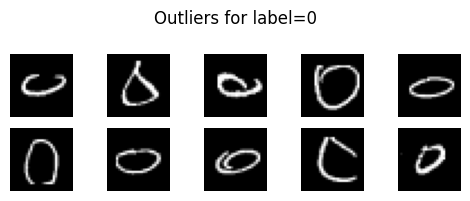

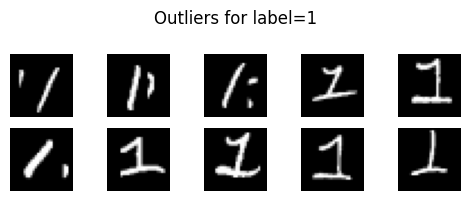

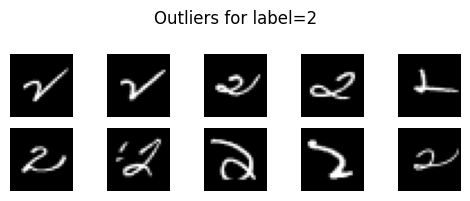

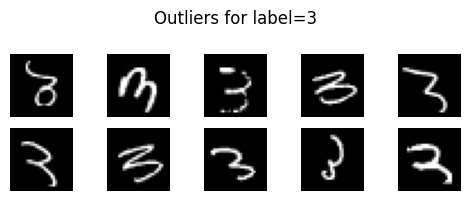

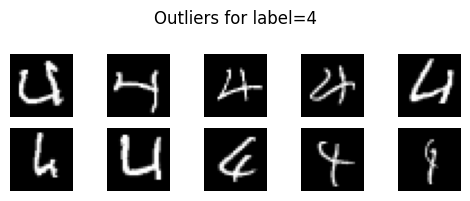

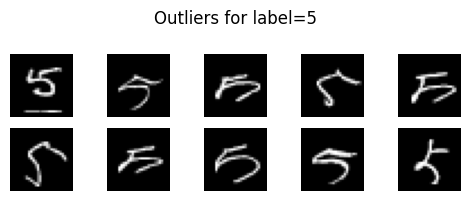

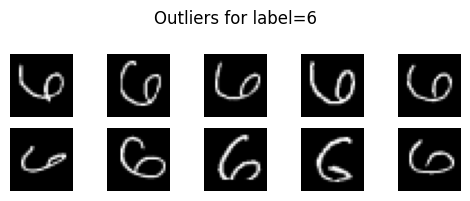

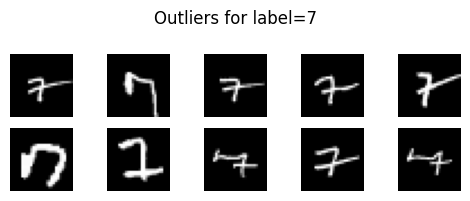

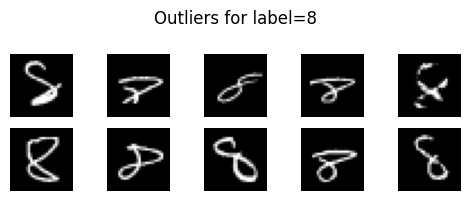

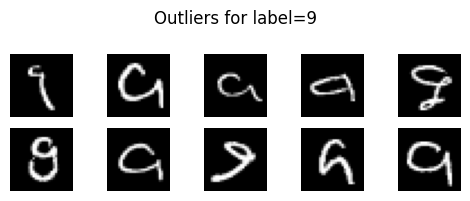

In [77]:
for label in range(10):
    label_data = train[train.label == label]
    # outliers = label_data[ood_train_feature_scores[label] < 0.7][:10]
    out_idxs = find_top_issues(quality_scores=ood_train_feature_scores[label], top=10)
    outliers = label_data.iloc[out_idxs][:10]

    images = [get_image(row) for _, row in outliers.iterrows()]
    plot_images(list(zip(images, [label]*len(images))), title=f"Outliers for label={label}")

## Centroids

In [12]:
outliers = defaultdict(list)

for label in range(10):
    label_data = train_data[label].reshape((-1, 28*28)) / 255
    
    centroid = label_data.mean(axis=0)
    std = label_data.std()
    
    for i, item in enumerate(label_data):
        if np.abs(item - centroid).mean() > std:
            outliers[label].append(i)


In [13]:
for label, out_idxs in outliers.items():
    images = train_data[label][out_idxs]
    labels = [label] * len(images)
    figsize = (9, 7) if len(images) > 10 else (5, 2)
    plot_images(list(zip(images, labels)), title=f"{label}: outliers", figsize=figsize)

# UMAP

In [68]:
import umap
reducer = umap.UMAP()
embeddings = reducer.fit_transform(train_features)

(60000, 2)

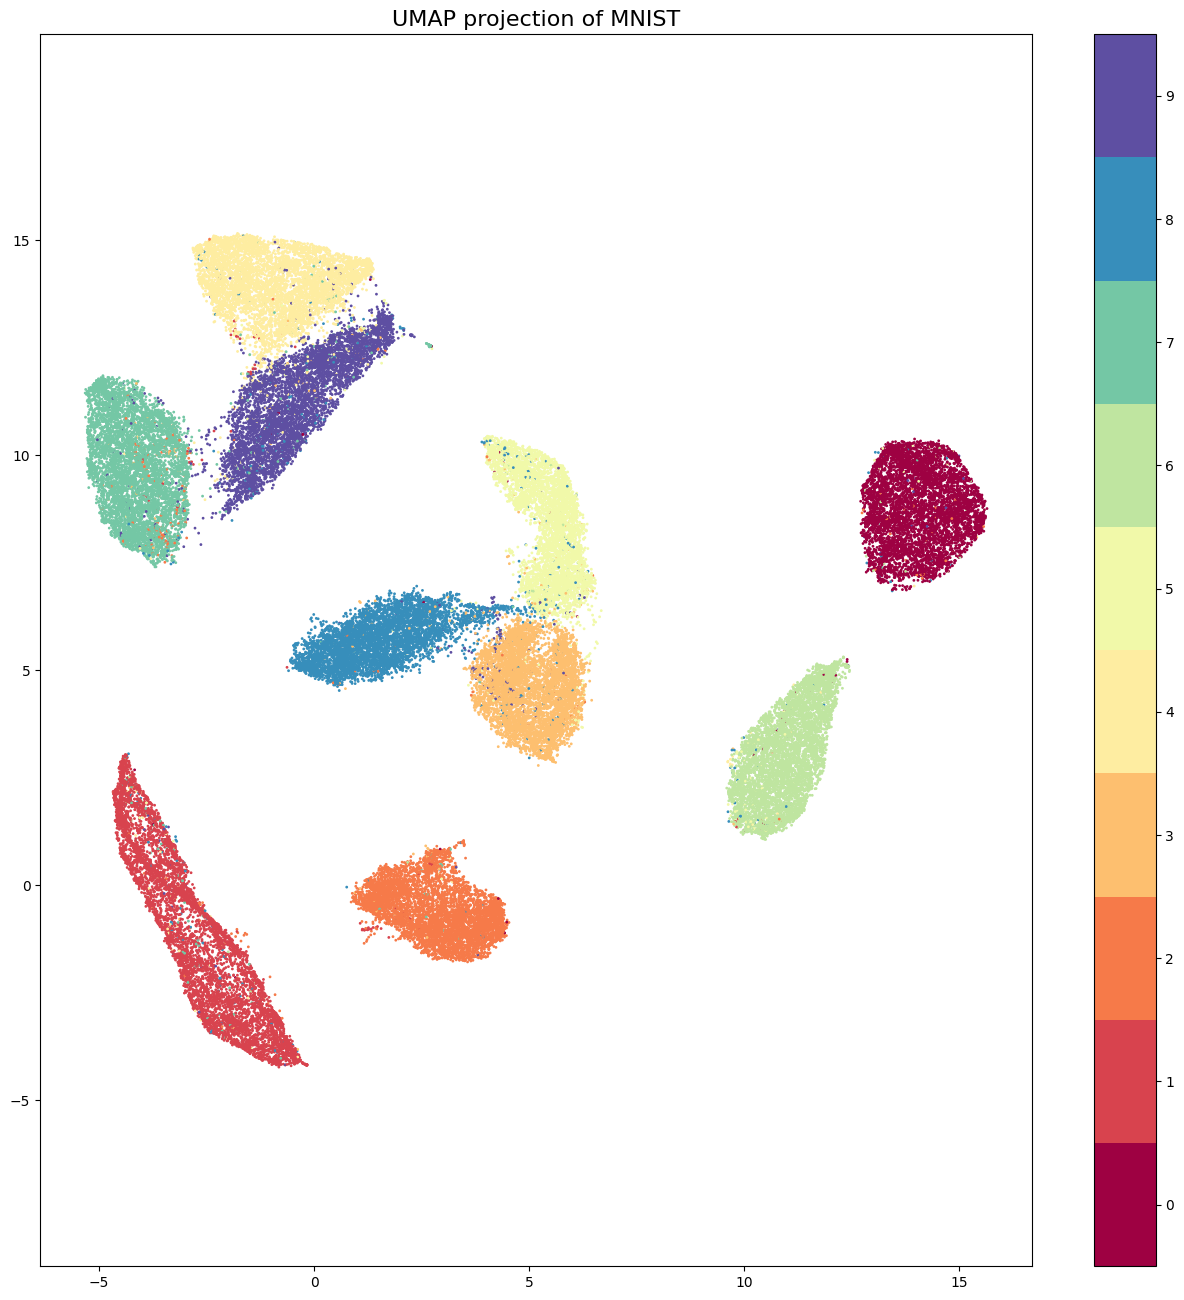

In [144]:
plt.rcParams["figure.figsize"] = (16, 16)
plt.scatter(embeddings[:, 0], embeddings[:, 1], c=train.label, cmap='Spectral', s=1)
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))
plt.title('UMAP projection of MNIST', fontsize=16)
plt.show()

In [78]:
from sklearn.preprocessing import StandardScaler
scaled_embeddings = StandardScaler().fit_transform(embeddings)

ood_train_feature_scores = []
for i in tqdm(range(10)):
    ood_train_feature_scores.append(
        OutOfDistribution().fit_score(features=scaled_embeddings[train.label == i])
    )

  0%|          | 0/10 [00:00<?, ?it/s]

Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...


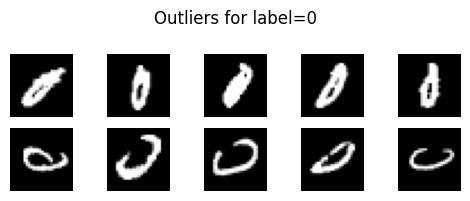

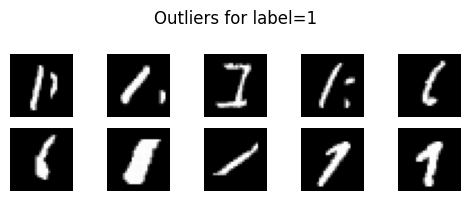

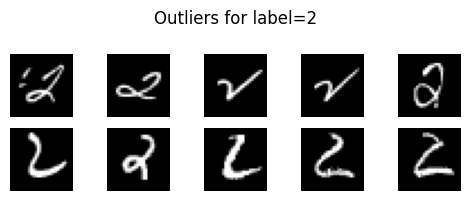

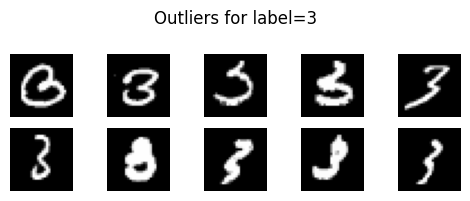

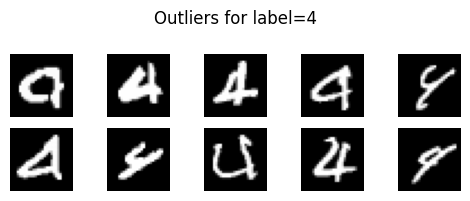

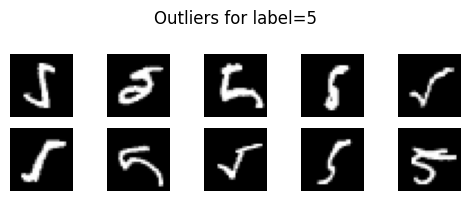

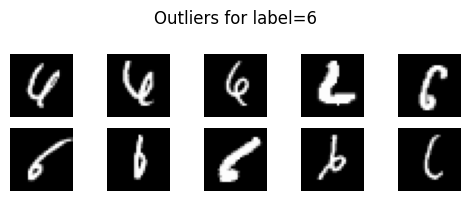

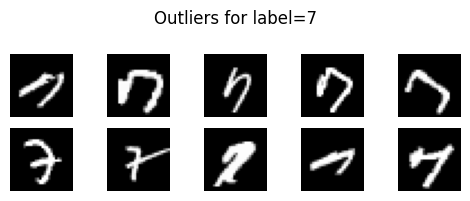

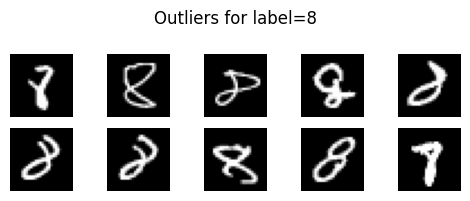

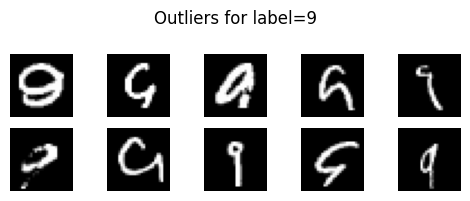

In [111]:
for label in range(10):
    label_data = train[train.label == label]    
    out_idxs = find_top_issues(quality_scores=ood_train_feature_scores[label], top=10)
    outliers = label_data.iloc[out_idxs][:10]
    images = [get_image(row) for _, row in outliers.iterrows()]
    plot_images(list(zip(images, [label]*len(images))), title=f"Outliers for label={label}")

# Clean dataset

In [136]:
train_clean = []
for label in range(10):
    label_data = train[train.label == label]    
    m = ood_train_feature_scores[label].mean()
    std = ood_train_feature_scores[label].std()
    out_idxs = ood_train_feature_scores[label] < m - 1 * std
    clean_label_data = label_data.iloc[~out_idxs]
    train_clean.append(clean_label_data)
train_clean = pd.concat(train_clean, ignore_index=True)
train_clean.shape[0]

58334

In [137]:
train_clean_features = normalize(train_clean[cols[1:]].to_numpy())
reducer = umap.UMAP()
embeddings_clean = reducer.fit_transform(train_clean_features)

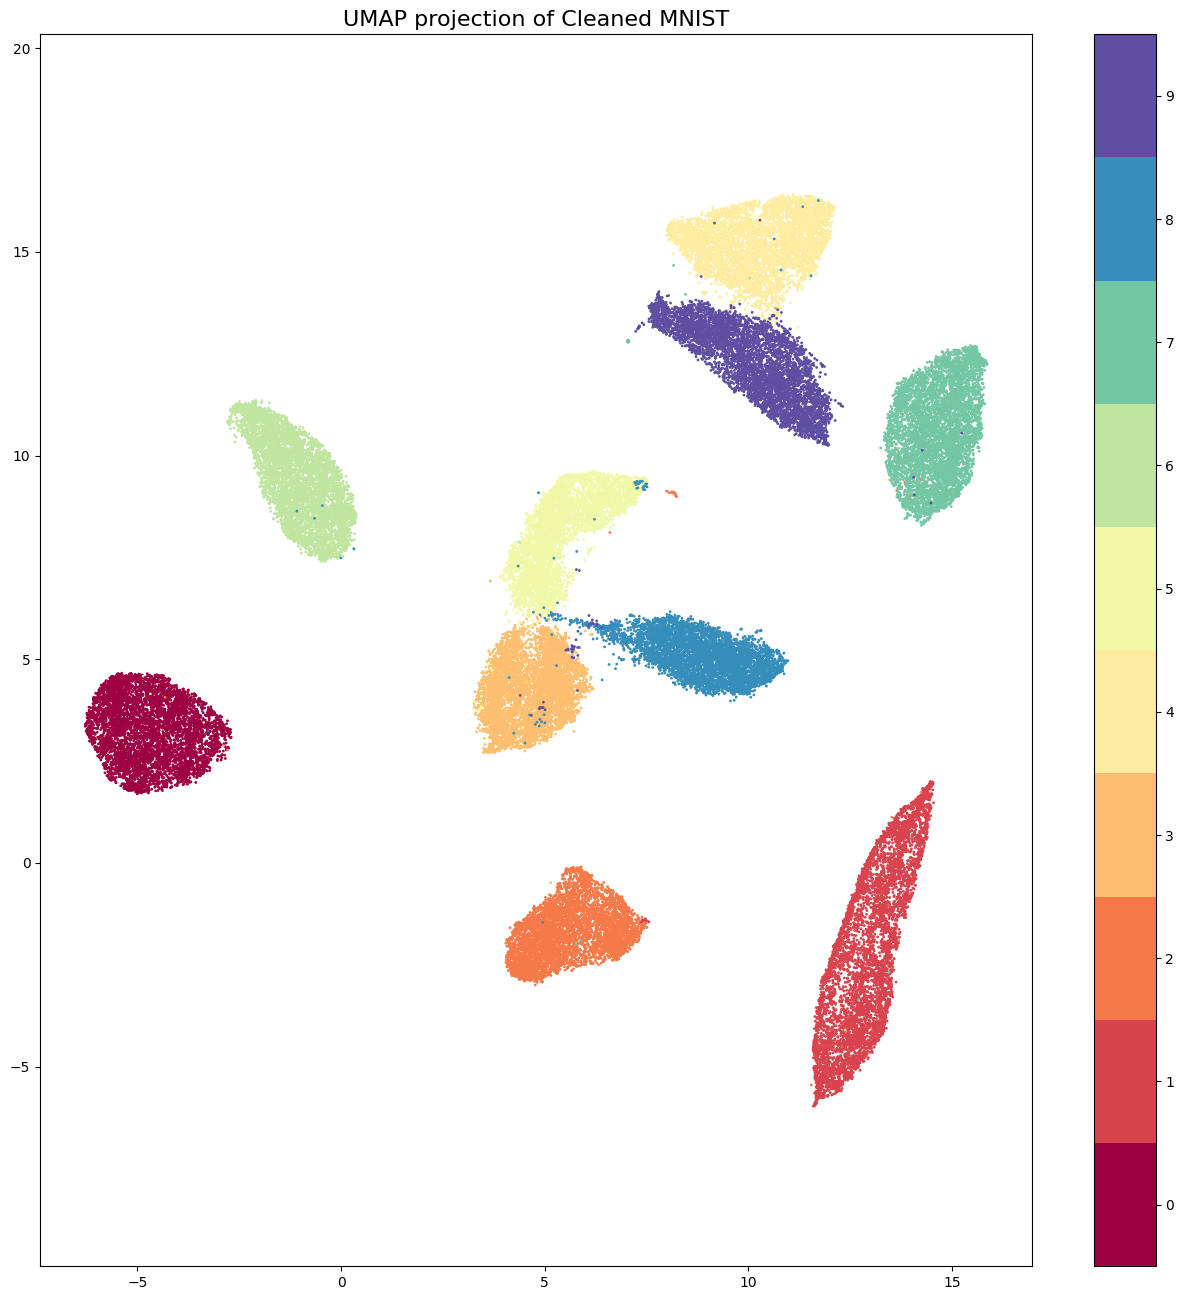

In [145]:
plt.rcParams["figure.figsize"] = (16, 16)
plt.scatter(embeddings_clean[:, 0], embeddings_clean[:, 1], c=train_clean.label, cmap='Spectral', s=1)
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))
plt.title('UMAP projection of Cleaned MNIST', fontsize=16)
plt.show()

<Axes: xlabel='label', ylabel='count'>

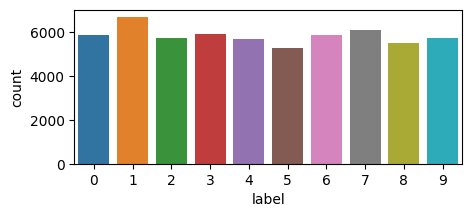

In [149]:
plt.rcParams["figure.figsize"] = (5, 2)
sns.countplot(train_clean, x="label")